In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import  OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the train and test datasets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')

In [3]:
# Separate features and target for train and validation data

X_train = df_train.drop(["id", "Age"], axis=1)
y_train = df_train["Age"]

X_test = df_test.drop(["id"], axis=1)

In [4]:
# One Hot Ecoding using OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(X_train[["Sex"]])
one_hot_encoded_test = one_hot_encoder.transform(X_test[["Sex"]])

In [5]:
# Convert to DataFrame
df_encoded_train = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(["Sex"]))

# Concatenate with the encoded column to the train and test
X_train = pd.concat([X_train.reset_index(drop=True), df_encoded_train.reset_index(drop=True)], axis=1)

X_train.drop(["Sex"], axis=1, inplace=True)

In [6]:
# Convert to DataFrame
df_encoded_test = pd.DataFrame(one_hot_encoded_test, columns=one_hot_encoder.get_feature_names_out(["Sex"]))

# Concatenate with the encoded column to the test and test
X_test = pd.concat([X_test.reset_index(drop=True), df_encoded_test.reset_index(drop=True)], axis=1)

X_test.drop(["Sex"], axis=1, inplace=True)

In [7]:
X_train.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,0.0,1.0,0.0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,0.0,1.0,0.0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,0.0,0.0,1.0
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,1.0,0.0,0.0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,0.0,1.0,0.0


In [8]:
y_train.head()

0     9
1     8
2     9
3    11
4     8
Name: Age, dtype: int64

In [9]:
X_test.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552,0.0,1.0,0.0
1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930,0.0,1.0,0.0
2,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415,1.0,0.0,0.0
3,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676,1.0,0.0,0.0
4,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066,0.0,1.0,0.0


In [10]:
def evaluate_model(model, X, y, n_splits=10):
    """
    Evaluates the given model using cross-validation and calculates the Mean Absolute Errors.

    Parameters:
    -----------
    model (estimator object): The model to be evaluated.
    X (DataFrame): The feature matrix.
    y (Series): The target variable.
    n_splits (int): The number of folds for cross-validation.

    Returns:
    --------
    mae_scores (list): A list of MAE for each fold.
    """
    # Initialize a list to store the MAE
    mae_scores = []

    # Create a KFold object for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=5)

    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        # Split the data into train and test sets for the current fold
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the training data
        model.fit(X_train_cv, y_train_cv)

        # Predict for the test
        y_pred = model.predict(X_test_cv)

        # Round y_pred to the nearest integer
        y_pred = np.round(y_pred).astype(int)

        # Calculate the MAE for the current fold
        mae = mean_absolute_error(y_test_cv, y_pred)
        mae_scores.append(mae)

    # Return the MAE, rounded to 3 decimal places
    return [round(value, 3) for value in mae_scores]

In [11]:
# Initialize the models

models = {
    "LightGBM": lgb.LGBMRegressor(random_state=5),
    "CatBoost": CatBoostRegressor(silent=True, random_seed=5),
}

Model: LightGBM
MAE Scores: [1.427, 1.352, 1.356, 1.361, 1.375, 1.381, 1.385, 1.378, 1.358, 1.37]
Average MAE: 1.374
Std Deviation: 0.021

Model: CatBoost
MAE Scores: [1.429, 1.358, 1.351, 1.365, 1.362, 1.379, 1.384, 1.377, 1.365, 1.375]
Average MAE: 1.375
Std Deviation: 0.021



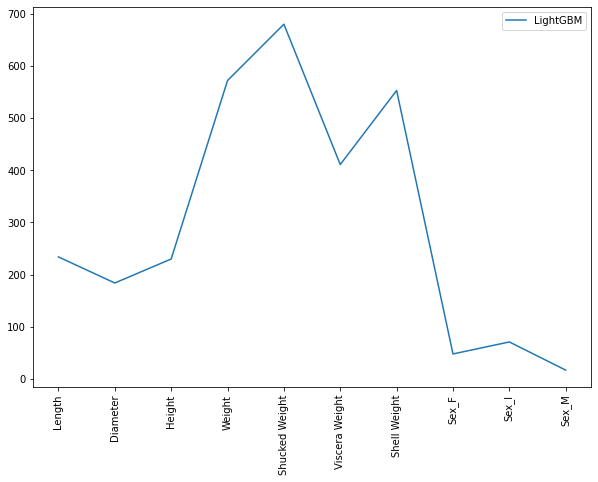

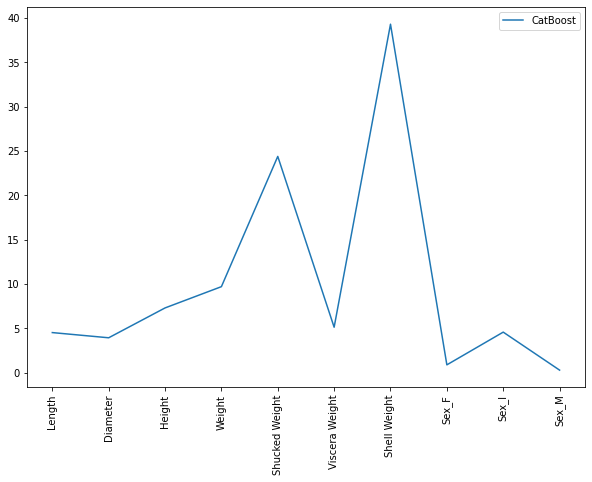

In [12]:
# Evaluate each model using the best subset of features
for name, model in models.items():
    """
    Loops through each model, and evaluates the model using cross-validation. 
    Prints the MAE scores, average MAE, and standard deviation
    for each model.
    """
    # Evaluate the model using cross-validation with the selected features
    mae_scores = evaluate_model(model, X_train, y_train)
    mean_mae = np.mean(mae_scores)
    std = np.std(mae_scores)

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Predict for the test set
    y_test_pred = model.predict(X_test)

    df_test["Age"] = np.round(y_test_pred).astype(int)

    # Save the output DataFrame to a CSV file
    df_test[["id", "Age"]].to_csv(f"submission_{name}.csv", index=False)

    # Print the results for the current model
    print(f"Model: {name}")
    print(f"MAE Scores: {mae_scores}")
    print(f"Average MAE: {mean_mae:.3f}")
    print(f"Std Deviation: {std:.3f}")

    try:
        plt.figure(figsize=(10, 7))
        plt.plot(model.feature_importances_, label=name)
        plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90)
        plt.legend()
    
    except AttributeError: # Incase the model does not have "feature_importances_"
        pass
    
    print()